Back to the main [Index](../index.ipynb)

# Phonons and Born effective charges with Abinit and AbiPy

This lesson shows how to compute phonon band structures, DOSes 
and Born effective charges with Abinit and AbiPy.
The dicussion closely follows the [second lesson](https://www.abinit.org/sites/default/files/last/tutorial/lesson_rf2.html)
on response functions available on the Abinit web-site. 

More specifically, we'll discuss how to

   * Perform a converge study for the phonon frequencies at $\Gamma$ as function of `ecut`
   * Compute the full phonon band structure of `AlAs` with the inclusion of LO-TO splitting
   * Obtain thermodinamical properties withing the harmonic approximation

We assume that you have read the literature relative to the [first Abinit lesson](https://www.abinit.org/sites/default/files/last/tutorial/lesson_rf2.html)
on response functions.
You might find additional material, related to the present section, in the following references: 

   * X. Gonze and C. Lee, Phys. Rev. B55, 10355 (1997), especially section IX 
   * C. Lee, X. Gonze, Phys. Rev. B 51, 8610 (1995) 
   * S. Baroni, S. de Gironcoli, A. Dal Corso, P. Giannozzi, Rev. Mod. Phys. 73, 515 (2001).

## Phonon frequencies at $\Gamma$ as function of ecut

Before starting, we need to import the python modules and the functions we will need in the notebook:

In [1]:
# Use this at the beginning of your script so that your code will be compatible with python3
from __future__ import print_function, division, unicode_literals

import numpy as np
import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

# Use seaborn settings for plots (optional)
import seaborn as sns  
sns.set(context='notebook', style='darkgrid', palette='deep',
        font='sans-serif', font_scale=1, color_codes=False, rc=None)

from abipy import abilab
import abipy.flowtk as flowtk

# This line tells the notebook to show plots inside of the notebook
%matplotlib notebook

and an useful function from the `lesson_dfpt` module that will be used to generate our DFPT flows:

In [2]:
from lesson_dfpt import make_scf_input
abilab.print_source(make_scf_input)

The function makes some assumptions for important parameters such as 
the crystalline structure and the pseudos to be used. 
This is done on purpose to to keep the code as simple as possible.
It should not be so difficult to generalize the implementation to take into account other cases.

Let's start to play with our new function:

In [3]:
scf_input = make_scf_input()
scf_input

<AbinitInput at 4748363760>

As you can see, we essentialy have a standard input to perform a GS calculation. This object will represent
the **building block** for our DFPT calculation with AbiPy.

It this is not your first time you use the DFPT part of Abinit, you already know that phonon calculations
require an initial GS run to produce the `WFK` file 
followed by a DFPT run that reads the `WFK` file and solves the Sternheimer equations for $N_{\text{irred}}(q)$ 
atomic perturbations where $N_{\text{irred}}$ is the number of independent atomic displacements (assuming $q$ belongs to the k-mesh).

If you try to do a convergence study wrt `ecut` **without multi-datasets**, you will likely start from an initial GS input file with a given value of `ecut`, use it as a template to generate the DFPT input files, create symbolic 
links to the `WFK` file produced in the first GS step and then instruct Abinit to read this file with `irdwfk`.
Once you have a set of input files that work for a particular `ecut`, one can simply replicate the set of 
directories and files and use a script to change the value of `ecut` in the input files.
Then, of course, one has to run the calculations manually, collect the results and produce nice plots to understand
what's happening.

This approach is obviously boring and error-prone if you are a human-being but it's easy to implement in an algorithm 
and machines do not complain if they have a lot of repetive work to do!
There are also several **technical advantages** in using this **task-based approach vs multi-datasets** but we discuss this point in more details afterwards. 

If the machine could speak, it will tell you: give me an object that represents an input for GS calculations,
give me the list of q-points you want to compute as well as the parameters that must be changed in the initial input 
and I will generate a `Flow` for DFPT calculations.
This logic appears so frequenty that we decided to encapsulate it in the `flowtk.phonon_conf_flow` factory function: 

In [4]:
from lesson_dfpt import build_flow_alas_ecut_conv
abilab.print_source(build_flow_alas_ecut_conv)

In [44]:
#import abipy.flowtk as flotwtk
#abilab.print_source(flowtk.phonon_conv_flow)

Let' call the function to build our flow:

In [5]:
flow = build_flow_alas_ecut_conv(None)

flow.show_info()

<Flow, node_id=231177, workdir=flow_alas_ecut_conv>
Number of works: 6, total number of tasks: 9
Number of tasks with a given class:

Task Class      Number
------------  --------
ScfTask              3
PhononTask           6

and call `plot_networkx` to visualize the connection among the `Tasks`:

<IPython.core.display.Javascript object>


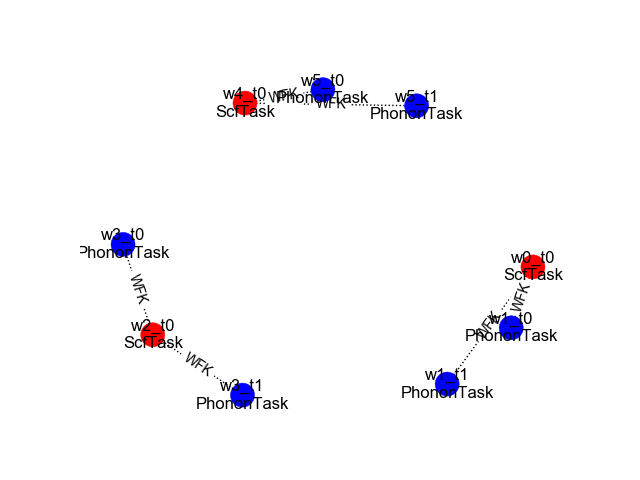

In [6]:
flow.plot_networkx(with_edge_labels=True);

The flow contains three independent groups of tasks, one group per each value of `ecut` specified in `params`.
Each group represents a `Workflow` and consists of one `ScfTask`(red circle) that solves the `KS` equations self-consistently producing a `WFK` file that will be used by the two children (`PhononTasks` - blue circles)
to compute the first-order change of the wavefunctions due to one of the *irreducible* atomic pertubations.

Note that `phonon_conv_flow` invokes Abinit under the hood to get the list of irreducible perturbations 
and uses this information to build the flow.
This explains why we have two `PhononTasks` per $q$-point instead of the total number of phonon modes that 
equals $3*N_{atom}=6$. 

It's also possible to get the textual representation of the dependency graph with:

In [7]:
flow.show_dependencies()

<ScfTask, node_id=231179, workdir=flow_alas_ecut_conv/w0/t0>

<PhononTask, node_id=231182, workdir=flow_alas_ecut_conv/w1/t0, rfphon: 1, qpt: [0.0, 0.0, 0.0], rfatpol: [1, 1], rfdir: [1, 0, 0]>
  +--<ScfTask, node_id=231179, workdir=flow_alas_ecut_conv/w0/t0>

<PhononTask, node_id=231183, workdir=flow_alas_ecut_conv/w1/t1, rfphon: 1, qpt: [0.0, 0.0, 0.0], rfatpol: [2, 2], rfdir: [1, 0, 0]>
  +--<ScfTask, node_id=231179, workdir=flow_alas_ecut_conv/w0/t0>

<ScfTask, node_id=231185, workdir=flow_alas_ecut_conv/w2/t0>

<PhononTask, node_id=231188, workdir=flow_alas_ecut_conv/w3/t0, rfphon: 1, qpt: [0.0, 0.0, 0.0], rfatpol: [1, 1], rfdir: [1, 0, 0]>
  +--<ScfTask, node_id=231185, workdir=flow_alas_ecut_conv/w2/t0>

<PhononTask, node_id=231189, workdir=flow_alas_ecut_conv/w3/t1, rfphon: 1, qpt: [0.0, 0.0, 0.0], rfatpol: [2, 2], rfdir: [1, 0, 0]>
  +--<ScfTask, node_id=231185, workdir=flow_alas_ecut_conv/w2/t0>

<ScfTask, node_id=231191, workdir=flow_alas_ecut_conv/w4/t0>

<PhononTask, node_

Now we can generate the directories and the input files of the `Flow` with:

    flow.build_and_pickle_dump()

and then use the `abirun.py` script to launch the entire calculation:

    abirun.py flow_alas_ecut_conv scheduler
    
You may want to run this example in the terminal if you've already installed and configured AbiPy and Abinit
on your machine. 
You will see that all `PhononTasks` will be executed in parallel on your machine and ...

If you prefer to skip this part, you may want to jump to next section about the post-processing of the results.
Note that the output files are already available in the repository so it's also possible to try 
the AbiPy post-processing tools without having to run the flow.

### Post-processing

There are several output files located inside the `outdata` directories:

In [8]:
!find flow_alas_ecut_conv/ -name "*_DDB"

flow_alas_ecut_conv//w0/t0/outdata/out_DDB
flow_alas_ecut_conv//w1/outdata/out_DDB
flow_alas_ecut_conv//w2/t0/outdata/out_DDB
flow_alas_ecut_conv//w3/outdata/out_DDB
flow_alas_ecut_conv//w4/t0/outdata/out_DDB
flow_alas_ecut_conv//w5/outdata/out_DDB


Remember that our goal is to analyze the convergence of the phonon frequencies at $\Gamma$ 
as function of `ecut`.
So we are mainly interested in the DDB files located in the `outdata` directories 
of the `PhononWorks` (`w0/outdata`, `w1/outdata`, `w2/outdata`).
These are indeed the DDB files with all the information needed to reconstruct the 
dynamical matrix at $\Gamma$ and to compute the phonon frequencies (AbiPy calls `mrgddb`
to merge the DDB files when all the perturbations in the `PhononWork` have been computed)

The code below tells our robot that we would like to analyze all the DDB files 
located in the output directories of the works:

In [9]:
#abilab.DirTreePlotter("./flow_alas_ecut_conv/").plot(filter_ends=["_DDB"]);

In [10]:
robot = abilab.DdbRobot.from_dir_glob("./flow_alas_ecut_conv/w*/outdata/")

Now we ask the robot to call `anaddb` to compute the phonon frequencies at $\Gamma$ for all DDBs 
and return a pandas `DataFrame`:

In [11]:
data_gamma = robot.get_dataframe_at_qpoint((0, 0, 0))

The `DataFrame` is a dict-like object whose keys are the name of the colums in the table

In [12]:
print(data_gamma.keys())

Index(['mode0', 'mode1', 'mode2', 'mode3', 'mode4', 'mode5', 'nkpt', 'nsppol',
       'ecut', 'ixc', 'tsmear', 'formula', 'natom', 'angle0', 'angle1',
       'angle2', 'a', 'b', 'c', 'volume', 'abispg_num', 'spglib_symb',
       'spglib_num'],
      dtype='object')


where `mode-i` is the frequency in eV of the i-th phonon mode.

We are mainly interested in the convergence of the phonon frequencies versus `ecut` so we filter these columns with:

In [13]:
data_gamma = data_gamma[["ecut"] + [k for k in data_gamma if k.startswith("mode")]]
data_gamma

,ecut,mode0,mode1,mode2,mode3,mode4,mode5
flow_alas_ecut_conv/w1/outdata/out_DDB,4.0,0.0,0.0,0.0,0.043641,0.043641,0.043641
flow_alas_ecut_conv/w3/outdata/out_DDB,6.0,0.0,0.0,0.0,0.044485,0.044485,0.044485
flow_alas_ecut_conv/w5/outdata/out_DDB,8.0,0.0,0.0,0.0,0.044625,0.044625,0.044625


and we get some statistics about our data with:

In [14]:
data_gamma.describe()

,ecut,mode0,mode1,mode2,mode3,mode4,mode5
count,3.0,3.0,3.0,3.0,3.000000,3.000000,3.000000
mean,6.0,0.0,0.0,0.0,0.044250,0.044250,0.044250
std,2.0,0.0,0.0,0.0,0.000533,0.000533,0.000533
min,4.0,0.0,0.0,0.0,0.043641,0.043641,0.043641
25%,5.0,0.0,0.0,0.0,0.044063,0.044063,0.044063
50%,6.0,0.0,0.0,0.0,0.044485,0.044485,0.044485
75%,7.0,0.0,0.0,0.0,0.044555,0.044555,0.044555
max,8.0,0.0,0.0,0.0,0.044625,0.044625,0.044625


Pandas tables are extremly powerful and the `describe` method already gives some useful info 
about the convergence of the phonon modes. 
Sometimes, however, we would like to visualize the data to have a better understanding of what's happening:

<IPython.core.display.Javascript object>


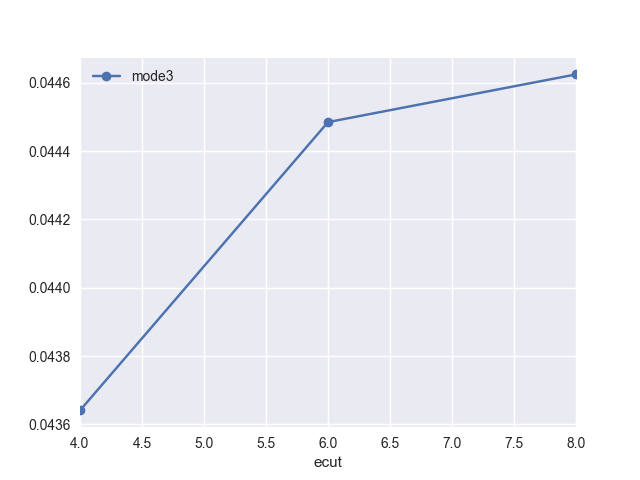

In [15]:
data_gamma.plot(x="ecut", y="mode3", style="-o");

Let's plot all the modes in different subplots with:

<IPython.core.display.Javascript object>


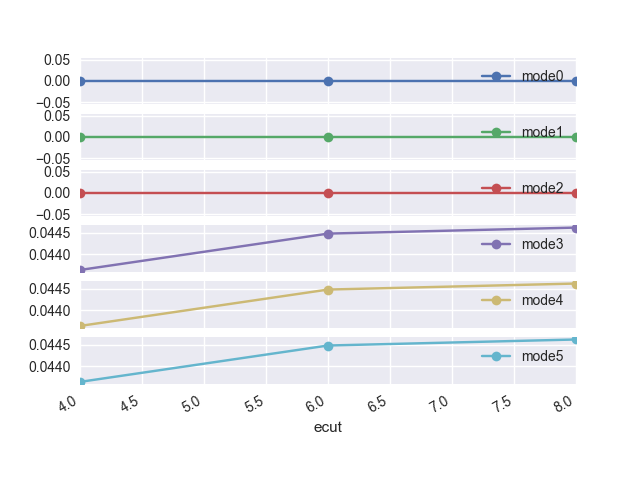

In [16]:
data_gamma.plot(x="ecut", y=[k for k in data_gamma if k.startswith("mode")], subplots=True, style="-o");

This convergence study at $\Gamma$ has thus revealed that our pseudos requires 
an `ecut` >= 6 Ha to get reasonably converged phonon frequencies at $\Gamma$.
In what follows, we assume that also the modes at the other $q$-points present a similar
convergence behaviour and we use `ecut` = 6 to keep the computational cost low. 

For a quick introduction to Pandas, see:

   * [A practical introduction to IPython Notebook & pandas](http://nbviewer.ipython.org/github/jvns/talks/blob/master/pydatanyc2013/PyData%20NYC%202013%20tutorial.ipynb)
   * [Diving into Open Data with IPython Notebook & Pandas](http://nbviewer.ipython.org/github/jvns/talks/blob/master/pyconca2013/pistes-cyclables.ipynb)

## Phonon band structure of AlAs

Now we are finally ready for the calculation of the vibrational spectrum of $AlAs$.
We already managed to run DFPT calculations at $\Gamma$ with different values of `ecut` and the
steps required to get a full band structure are not that different, provided that 
the following differences are taken into account:

- we need the dynamical matrix $D(q)$ on a homogeneous mesh so that it's possible to calculate $D(R)$
  in anaddb via Fourier transform and then phonon frequencies for arbitrary q-points via Fourier interpolation
  
- $AlAs$ is a polar semiconductor so we need to include the LO-TO splitting for $q \rightarrow 0$ that, in turns,
  requires the DFPT computation of the Born effective charges and of the dielectric constant.


In AbiPy, these concepts are translated in an easy-to-use API in which you pass an initial `AbinitInput` object,
you specify the q-mesh for phonons in terms of `ph_nqpt` and activate the computation of the 
Born effective charges with the boolean flag `with_becs`.

Let's have a look at the code (as usual there are more comments that lines of code):

In [17]:
from lesson_dfpt import build_flow_alas_phonons
abilab.print_source(build_flow_alas_phonons)

We can finally construct the flow with:

In [18]:
flow_phbands = build_flow_alas_phonons(options=None)

and visualize the connections with:

<IPython.core.display.Javascript object>


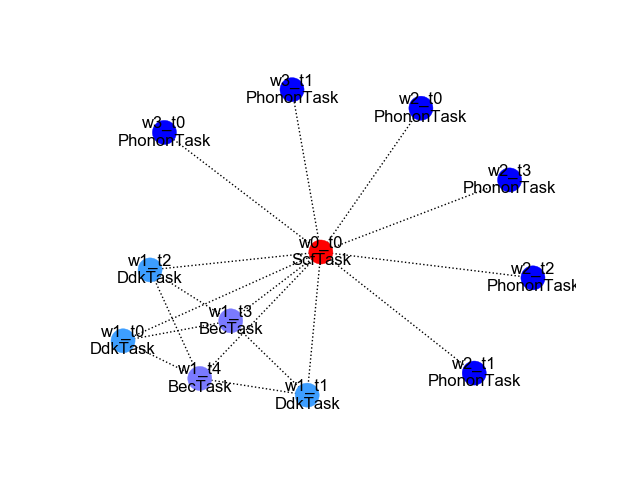

In [19]:
flow_phbands.plot_networkx();

Note that there are a lot of things happening under the hood here.

First of all, AbiPy generates `PhononTasks` only for the $q$-points in the 
irreducible wedge of the Brillouin zone corresponding to `ph_ngqpt`.
Moreover, for a given $q$-point, only the irreducible atomic perturbations are explictly computed
since the other atomic perturbations can be recostructed by symmetry.
Fortunately you don't have to care about all these technical details as AbiPy and Abinit 
will automate the whole procedure.

Remember that the $q$-point mesh cannot be chosen arbitrarily
since all $q$ wavevectors should connect two $k$ points of the grid used for the electrons.

Now we can generate the directories and the input files of the `Flow` with:

    flow.build_and_pickle_dump()

and then use the `abirun.py` script to launch the entire calculation:

    abirun.py flow_alas_phonons scheduler

### Post-processing

Our flow is completed and we have the final DDB file with all the $q$-points and all the independent atomic perturbations. 
Let's open this DDB file with:

In [20]:
ddb = abilab.abiopen("flow_alas_phonons/outdata/out_DDB")
print(ddb)

================================= File Info =================================
Name: out_DDB
Directory: /Users/gmatteo/git_repos/abitutorials/abitutorials/dfpt/flow_alas_phonons/outdata
Size: 28.11 kb
Access Time: Mon Nov 13 11:23:13 2017
Modification Time: Thu Oct 12 22:34:40 2017
Change Time: Thu Oct 12 22:34:40 2017

================================= Structure =================================
Full Formula (Al1 As1)
Reduced Formula: AlAs
abc   :   3.970101   3.970101   3.970101
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c
---  ----  ----  ----  ----
  0  Al    0     0     0
  1  As    0.25  0.25  0.25

Abinit Spacegroup: spgid: 0, num_spatial_symmetries: 24, has_timerev: True, symmorphic: False

0) [+0.000, +0.000, +0.000], weight: 0.000
1) [+0.500, +0.000, +0.000], weight: 0.000
2) [+0.500, +0.500, +0.000], weight: 0.000

guessed_ngqpt: [2 2 2] (guess for the q-mesh divisions made by AbiPy)


The `DdbFile` object provides an easy-to-use interface that invokes `anaddb` to post-process
the data stored in the DDB file.

`anacompare_phdos`, for example, computes the phonon DOS with different $q$-meshes.
Each mesh is defined by a single integer, `nqsmall`, that gives the number of 
divisions used to sample the smallest reciprocal lattice vector. 
The number of divisions along the other directions are chosen so that proportions are preserved:

In [21]:
c = ddb.anacompare_phdos(nqsmalls=[8, 10, 12, 14, 16])

 Delta(Phdos[0] - Phdos[4]) / Phdos[4]: 0.955367
 Delta(Phdos[1] - Phdos[4]) / Phdos[4]: 0.694487
 Delta(Phdos[2] - Phdos[4]) / Phdos[4]: 0.419208
 Delta(Phdos[3] - Phdos[4]) / Phdos[4]: 0.240976


<IPython.core.display.Javascript object>


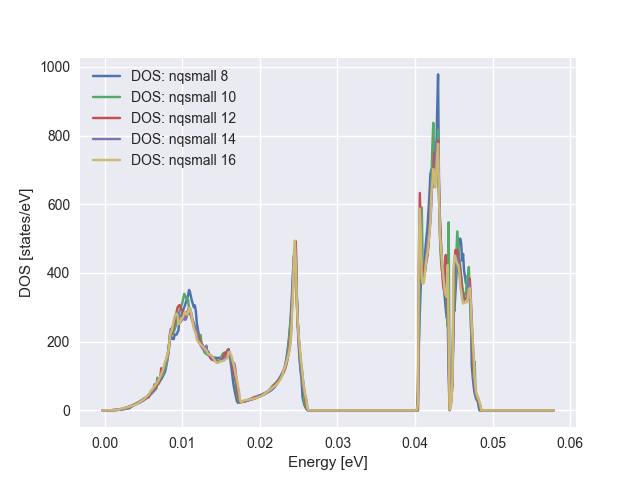

In [22]:
c.plotter.combiplot();

A 16x16x16 $q$-mesh with the tethraedron method gives a well converged phonon DOS.

To function `anaget_phbst_and_phdos_files` allows one to compute the phonon band structure on an automatically defined $q$-path as well as the the phonon DOS:

In [23]:
phbst_file, phdos_file = ddb.anaget_phbst_and_phdos_files(ndivsm=10, nqsmall=16)

# Extract the phonon bands and the phonon DOS from phbst_file and phdos_file
phbands = phbst_file.phbands 
phdos = phdos_file.phdos

Let's plot the bands with matplotlib:

<IPython.core.display.Javascript object>


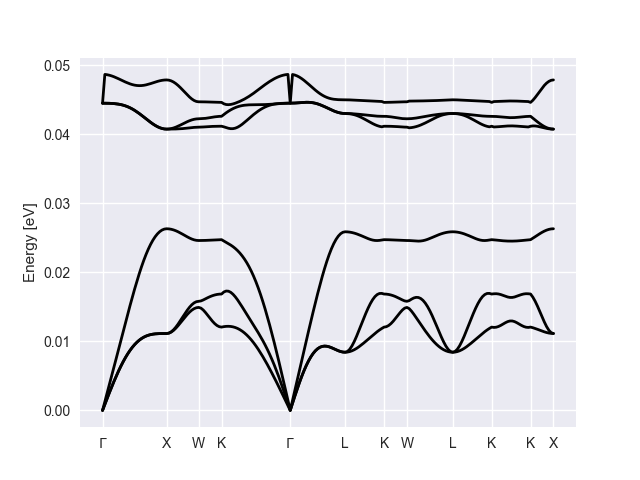

In [24]:
phbands.plot();

Do you see the two strange dips for the highest phonon band, at the $\Gamma$ point?
They are due to the lack of LO-TO splitting for the ANADDB treatment of the first list of vector. 
See also the discussion in the [second lesson](https://www.abinit.org/sites/default/files/last/tutorial/lesson_rf2.html).

For years, Abinit users had to patch manually the output frequencies to include the LO-TO splitting.
Now these days are finally gone and we can plot the LO-TO splitting with AbiPy by just using 
the `lo_to_splitting` option:

In [25]:
phbst_file, phdos_file = ddb.anaget_phbst_and_phdos_files(ndivsm=10, nqsmall=16, lo_to_splitting=True)

# Extract the phonon bands and the phonon DOS from phbst_file and phdos_file
phbands = phbst_file.phbands 
phdos = phdos_file.phdos

In [26]:
#phbst_file.phbands.qpoints.plot(); 

The band structure plot now correctly shows the non-analytical behaviour around $\Gamma$:

<IPython.core.display.Javascript object>


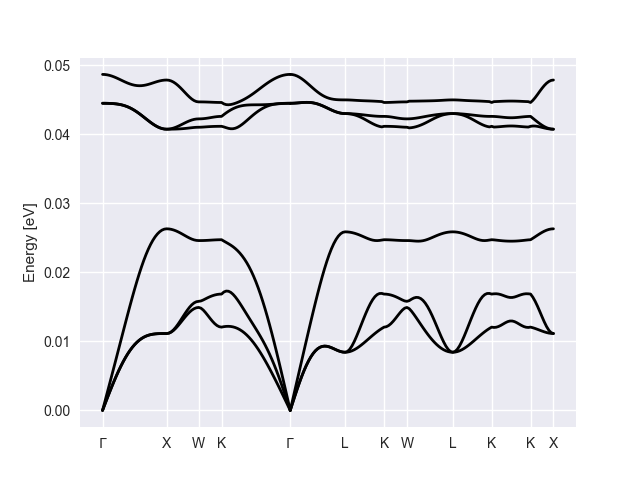

In [27]:
phbands.plot();

<div class="alert alert-warning">
`lo_to_splitting` works only the DDB contains the Born effective charges and the dielectric costant
that must be computed in the Abinit run.
</div>

To plot bands and DOS on the same figure:

<IPython.core.display.Javascript object>


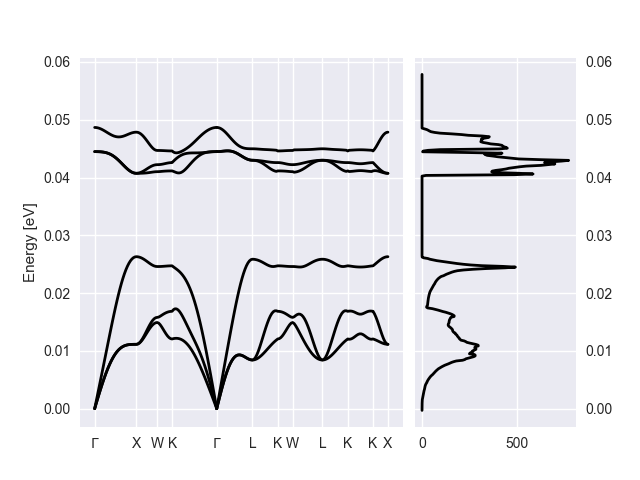

In [28]:
phbands.plot_with_phdos(phdos);

The `PhdosFile` contains the phonon frequencies, the displacement vectors
as well as the decomposition of the total DOS in terms of the contributions due to 
the different types of atom in the unit cell.
This means that one can plot the type-projected phonon DOS with:

<IPython.core.display.Javascript object>


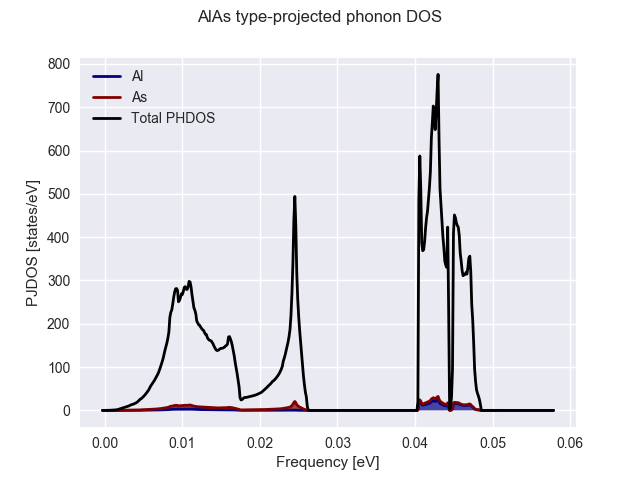

In [29]:
phdos_file.plot_pjdos_type(title="AlAs type-projected phonon DOS");

and it's even possible to plot fatbands and type-projected DOSes on the same figure with:

<IPython.core.display.Javascript object>


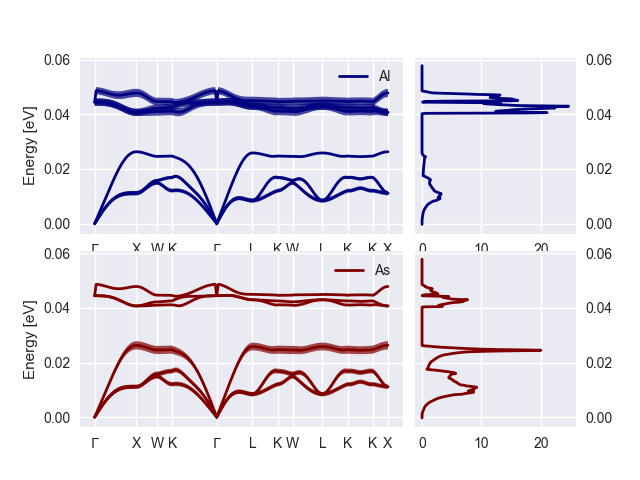

In [30]:
phbands.plot_fatbands(phdos_file=phdos_file);

The highest frequency modes have a strong Al-character while the low frequency modes originate from As. 
This behaviour is somehow expected. Could you explain it in terms of a simple physical model?   

## Macroscopic dielectric tensor and Born effective charges

Our calculations includes the response of the system to an external electric field.
The code below extracts the macroscopic dielectric tensor (`emacro`)
and the Born effective charges (`becs`) from the DDB file:

In [31]:
emacro, becs = ddb.anaget_emacro_and_becs()

In [32]:
emacro

(Tensor in r space.
 
 Cartesian coordinates:
 [[  1.03961652e+01   8.88178420e-16   8.88178420e-16]
  [  1.77635684e-15   1.03961652e+01   1.77635684e-15]
  [  1.77635684e-15   1.77635684e-15   1.03961652e+01]],)

In [33]:
becs

Born effective charges computed with chneut: 1
BEC at site: PeriodicSite: Al (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
[[  2.16805280e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.16805280e+00   0.00000000e+00]
 [ -2.08748765e-19  -2.08748765e-19   2.16805280e+00]]

BEC at site: PeriodicSite: As (1.4036, 1.4036, 1.4036) [0.2500, 0.2500, 0.2500]
[[ -2.16805280e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.16805280e+00   0.00000000e+00]
 [  2.08748765e-19   2.08748765e-19  -2.16805280e+00]]

Born effective charge neutrality sum-rule with chneut: 1
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.40741243e-35   2.40741243e-35   0.00000000e+00]]

As explained in the references, the Born effective charges must fulfill 
the charge neutrality sum-rule.
This rule is usually broken due to the discretization introduced by the FFT mesh, and `anaddb` will enforce it if `chneut` is set to 1 (default behaviour). Let's check it out!

In [34]:
becs.check_sumrule()

Born effective charge neutrality sum-rule with chneut: 1
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  2.40741243e-35   2.40741243e-35   0.00000000e+00]]

Let's repeat the same calculation but without enforcing the sum-rule:

In [35]:
emacro, becs_chneut0 = ddb.anaget_emacro_and_becs(chneut=0)
print(becs_chneut0)

Born effective charges computed with chneut: 0
BEC at site: PeriodicSite: Al (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
[[  2.12729461e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.12729461e+00   0.00000000e+00]
 [  8.19928209e-20   8.19928209e-20   2.12729461e+00]]

BEC at site: PeriodicSite: As (1.4036, 1.4036, 1.4036) [0.2500, 0.2500, 0.2500]
[[ -2.20881100e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -2.20881100e+00   0.00000000e+00]
 [  4.99490350e-19   4.99490350e-19  -2.20881100e+00]]

Born effective charge neutrality sum-rule with chneut: 0
[[ -8.15163891e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -8.15163891e-02   0.00000000e+00]
 [  5.81483171e-19   5.81483171e-19  -8.15163891e-02]]


In [36]:
becs_chneut0.check_sumrule()

Born effective charge neutrality sum-rule with chneut: 0
[[ -8.15163891e-02   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00  -8.15163891e-02   0.00000000e+00]
 [  5.81483171e-19   5.81483171e-19  -8.15163891e-02]]

## Thermodinamic properties within the harmonic approximation

It's well known that all the thermodinamic properties of an ensemble of non-interacting phonons can be 
expresses in terms of integrals of the DOS.

\begin{equation}
\label{eq:helmholtz}
\Delta F = 3nNk_BT\int_{0}^{\omega_L}\text{ln}\left(2\text{sinh}\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}

\begin{equation}
\label{eq:free_en}
\Delta E = 3nN\frac{\hbar}{2}\int_{0}^{\omega_L}\omega\text{coth}\left(\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}

\begin{equation}
\label{eq:c_v}
C_v = 3nNk_B\int_{0}^{\omega_L}\left(\frac{\hbar\omega}{2k_BT}\right)^2\text{csch}^2\left(\frac{\hbar\omega}{2k_BT}\right)g(\omega)d\omega
\end{equation}


\begin{equation}
\label{eq:entropy}
S = 3nNk_B\int_{0}^{\omega_L}\left(\frac{\hbar\omega}{2k_BT}\text{coth}\left(\frac{\hbar\omega}{2k_BT}\right) - \text{ln}\left(2\text{sinh}\frac{\hbar\omega}{2k_BT}\right)\right)g(\omega)d\omega,
\end{equation}

where $k_B$ is the Boltzmann constant.

This should represent a reasonable approximation especially in the low temperature 
regime in which anharmonic effects can be neglected.   

Let's plot the vibrational contributions thermodinamic properties as function of $T$: 

<IPython.core.display.Javascript object>


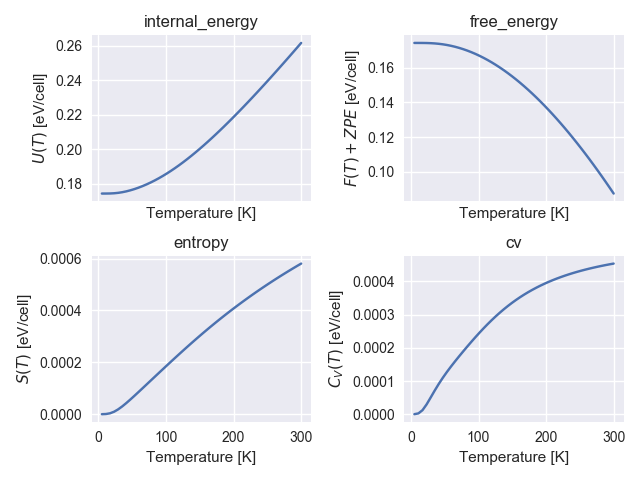

In [37]:
phdos.plot_harmonic_thermo();

## Exercises

    
* Our first phonon band structure has been computed with a (4, 4, 4) $k$-mesh 
  for the electrons and a (2, 2, 2) $q$-mesh for phonons. 
  You may try to increase the density of $k$-points/$q$-points
  to see if this change affects the final results.
        
* Why do you get an error from AbiPy if you try `ngkpt` = (4, 4, 4,) and `ngqpt` = (3, 3, 3)?